# BNNs

In [1]:
from bayesian_models import Pbnn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from doepy import build
import pickle
from scipy.stats import norm, uniform, lognorm
from scipy.stats import qmc    #for sobol seq. (LHS is also available in this QuasiMC library)

In [2]:
from LStates.four_branch import four_branch

function = four_branch

def convert_lognormal(mean_ln, std_ln):
    gaussian_param = np.zeros(2)

    SigmaLogNormal = np.sqrt( np.log(1+(std_ln/mean_ln)**2))
    MeanLogNormal = np.log( mean_ln ) - SigmaLogNormal**2/2

    gaussian_param[0] = MeanLogNormal
    gaussian_param[1] = SigmaLogNormal

    return gaussian_param

In [3]:
dim = 2
n_mcs = int(1e6)
x_test = np.random.normal(0, 1, size=(n_mcs, dim))

y_test = function(x_test)
Pf_ref = np.sum( y_test < 0 ) / n_mcs
B_ref= - norm.ppf( Pf_ref )
Pf_ref, B_ref

(0.004386, 2.6208144151726733)

to sample with sobol

In [4]:
sampler = qmc.Sobol(d=2, scramble=True)    #d=dimensionality
sample = sampler.random_base2(m=5)   #change m=exponent to increase the sample size

l_bounds = [-2.0, -2.0]  #design domain for each variable in the physical space
u_bounds = [2.0, 2.0]
X = qmc.scale(sample, l_bounds, u_bounds)

Y = function(X)
passive_samples = len(X)
print(passive_samples)

32


to sample with LHS

In [ ]:
passive_samples = 20
X = np.zeros((passive_samples, dim))

exp_norm = {}
for var_name in range(dim):
    exp_norm['x'+ str(var_name+1)] = [-2, 2]    #initial design domain for each variable in the physical space
#Latin hypercube sampling
Xdoe = build.space_filling_lhs(exp_norm , num_samples = passive_samples)

for margin in range (0, dim):
    var = 'x' + str (margin + 1)
    X[:, margin] = Xdoe[var]

Y = function(X)

Plot 2D - initial DoE

In [5]:
delta = 0.025
x1 = np.arange(-5.0, 5.0, delta)
x2 = np.arange(-5.0, 5.0, delta)
X1, X2 = np.meshgrid(x1, x2)
Xt=np.stack((X1,X2),axis=2).reshape(-1,2) #sorting the random sampling (graph purposes)
Yt = function(Xt)

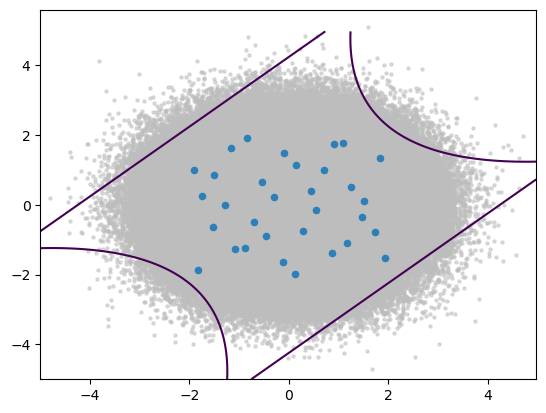

In [6]:
fig, ax = plt.subplots()
ax.scatter(x_test[:,0], x_test[:,1], s=5, alpha=0.5, c='#bdbdbd')
ax.scatter(X[:,0], X[:,1], s=20, alpha=1, c='#2c7fb8')
CS = ax.contour(X1, X2, Yt.reshape(len(x1),-1), [0])
# ax.clabel(CS, inline=False, fontsize=10)

BNN training

In [30]:
dim = 2
output = 1
layers, archit = 2 , [16, 16] #ange archit size if layers are increased

#-------------------------------------------creating bnn
#setting up the network architecture -----------------------------------
config = {"n_infeatures": dim,
        "n_outfeatures": output,
        "n_samples": len(X),
        "learn_all_params": False,  #to learn mean and sigma
        "fixed_param": 0.001} 

mybnn = Pbnn(config)
mybnn.build_bnn(layers, archit) #----------------------------------------------------------MODEL ARCHITECTURE

In [31]:
training_epochs = 5000
batch_size = len(X)
# batch_size = [np.floor_divide(len(X), 2)][0] + 1  # half of the DoE
#-------------------------------------------training bnn
train_env = {"batch_size": batch_size,
            "learning_rate": 0.001,
            "epochs": training_epochs,
            "callback_patience": 500,
            "verbose": 1,
            "valid_split":0.0}
print('Training BNN With', len(X), 'samples' )
history = mybnn.train_bnn(X, Y, train_env)

Training BNN With 42 samples
Epoch 1/5000
1/1 [==============================] - 1s 1s/step - loss: 1670454.1250
Epoch 2/5000
1/1 [==============================] - 0s 30ms/step - loss: 1659170.2500
Epoch 3/5000
1/1 [==============================] - 0s 6ms/step - loss: 1723083.0000
Epoch 4/5000
1/1 [==============================] - 0s 6ms/step - loss: 1763973.8750
Epoch 5/5000
1/1 [==============================] - 0s 6ms/step - loss: 1704583.2500
Epoch 6/5000
1/1 [==============================] - 0s 7ms/step - loss: 1701988.6250
Epoch 7/5000
1/1 [==============================] - 0s 5ms/step - loss: 1725747.6250
Epoch 8/5000
1/1 [==============================] - 0s 5ms/step - loss: 1712181.8750
Epoch 9/5000
1/1 [==============================] - 0s 6ms/step - loss: 1693797.7500
Epoch 10/5000
1/1 [==============================] - 0s 4ms/step - loss: 1770926.5000
Epoch 11/5000
1/1 [==============================] - 0s 5ms/step - loss: 1769121.0000
Epoch 12/5000
1/1 [===============

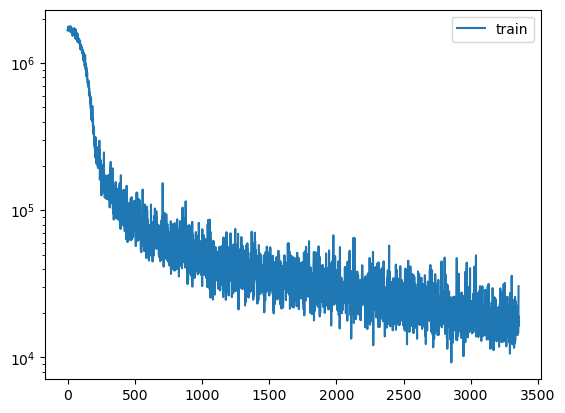

In [32]:
train_loss = history.history['loss']
# val_loss = history.history['val_loss']

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
# ax.plot(val_loss, label='valid')

ax.set_yscale('log')
plt.legend()
plt.show()

In [33]:
bnn_simulations = 300
Mean_muY_val, Stdv_muY_val, Mean_sigmaY_val, Stdv_sigmaY_val = mybnn.modeluq_bnn(Xt, nsim = bnn_simulations)

<a list of 2 text.Text objects>

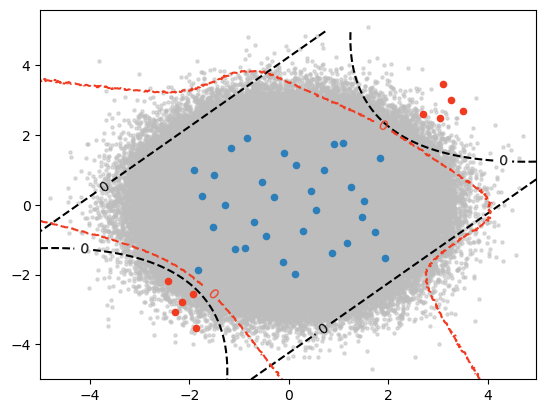

In [34]:
fig, ax = plt.subplots()
# ax.scatter(x_test[:,0], x_test[:,1], s=5, alpha=0.5, c='#bdbdbd')
ax.scatter(x_test[:,0], x_test[:,1], s=5, alpha=0.5, c='#bdbdbd')
ax.scatter(X[:passive_samples,0], X[:passive_samples,1], s=20, alpha=1, c='#2c7fb8')     #passive points
ax.scatter(X[passive_samples:,0], X[passive_samples:,1], s=20, alpha=1, c='#f03b20')     #active points
CS = ax.contour(X1, X2, Yt.reshape(len(x1),-1), [0], colors='k', linestyles='dashed')
CB = ax.contour(X1, X2, Mean_muY_val.reshape(len(x1),-1), [0.0], colors='#f03b20', linestyles='dashed')
ax.clabel(CS, inline=True, fontsize=10)
ax.clabel(CB, inline=True, fontsize=10)

In [27]:
n_mcs = int(1e6)
bnn_simulations = 300

exp = {'x1': [0, 1, 'normal'],
       'x2': [0, 1, 'normal']}

#-------------------------------------------MC population
Xtest = np.zeros((int(n_mcs), dim))
MCinputs_norm= np.random.uniform(0.000001, 0.999999, size=(int(n_mcs), dim))

##Iso-probabilistic transformation-------------------------------------------
for margin in range (0, dim):
    var = 'x' + str (margin + 1)

    if exp[var][2] == 'normal':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        Xtest[:, margin] = norm.ppf(MCinputs_norm[:, margin], loc=loc_, scale=scale_)

    elif exp[var][2] == 'uniform':
        loc_ = exp[var][0]
        scale_ = exp[var][1]
        Xtest[:, margin] = uniform.ppf(MCinputs_norm[:, margin], loc=loc_, scale=scale_-loc_)

    elif exp[var][2] == 'lognormal':
        xlog_mean = exp[var][0]
        xlog_std = exp[var][1]
        gaussian_param = convert_lognormal(xlog_mean, xlog_std)
        Xtest[:, margin] = lognorm.ppf(MCinputs_norm[:, margin], s=gaussian_param[1], scale=xlog_mean) 

#-------------------------------------------model predictions over MC population
print('BNN predictions with MC population...')
Mean_muY_MC, Stdv_muY_MC, Mean_sigmaY_MC, Stdv_sigmaY_MC = mybnn.modeluq_bnn(Xtest, nsim = bnn_simulations)
y_mcs = function(Xtest)

PF = np.sum(Mean_muY_MC < 0) / n_mcs
PF_ref = np.sum(y_mcs < 0) / n_mcs
B = - norm.ppf( PF )

print('PF_ref =', PF_ref,'PF =', PF, 'and B =',"%.5f" % round(B, 3))

BNN predictions with MC population...
PF_ref = 0.004328 PF = 0.00433 and B = 2.62500


Select MULTIPLE NEW training samples

In [28]:
learning_points = 5
#-------------------------------------------Selecting MULTIPLE NEW training point
# U_f = np.abs(Mean_muY_MC) / Stdv_muY_MC
U_f = Stdv_muY_MC

U_min_args = np.argsort(U_f.reshape(-1))     #ordering arguments from min to max
X_new = Xtest[U_min_args[:learning_points]]  #choosing a given number of MC samples from the minimum U values
X = np.concatenate((X, X_new), axis=0)

Y_new = function(X_new)
Y = np.concatenate((Y, Y_new), axis=0)
len(Y)

42

Select SINGLE NEW Training point

In [ ]:
#-------------------------------------------Selecting SINGLE NEW training point
U_f = np.abs(Mean_muY_MC) / Stdv_muY_MC
U_min = np.argmin(U_f)
X_new = Xtest[U_min].reshape(-1, dim)
# X = np.concatenate((X, X_new), axis=0)

Y_new = function(X_new)
# Y = np.concatenate((Y, Y_new), axis=0)
print(Y)